# 📊 AIOE 탐색적 데이터 분석 (Exploratory Data Analysis)

이 노트북은 01번에서 계산한 AIOE 데이터를 **모델링 전에 깊이 있게 탐색**하는 단계입니다.

---

## 🎯 EDA의 목적

**Exploratory Data Analysis (EDA)**는 머신러닝 모델링 전에 반드시 거쳐야 하는 필수 단계입니다.

### 왜 EDA가 중요한가?

1. **데이터의 본질 이해**: 숫자 뒤에 숨겨진 패턴과 의미 파악
2. **문제점 조기 발견**: 이상치, 결측치, 분포 왜곡 등을 미리 찾아냄
3. **모델링 전략 수립**: 어떤 변환이 필요한지, 어떤 변수가 중요한지 파악
4. **가설 검증**: 데이터가 우리의 직관이나 논문 결과와 일치하는지 확인

### 이 노트북에서 수행할 작업

| 단계 | 목적 | 주요 질문 |
|------|------|----------|
| 1. 데이터 로딩 | 분석 대상 확정 | 몇 개 직업? 어떤 변수? 결측치는? |
| 2. 기술 통계 | 기본 특성 파악 | 평균, 분산, 범위는? |
| 3. 분포 분석 | 변수의 형태 이해 | 정규분포? 치우침? 이상치? |
| 4. 로그 변환 | 분포 개선 | 변환 후 더 나아졌나? |
| 5. 상관관계 | 변수 간 관계 | AIOE와 임금은 관련 있나? |
| 6. 케이스 분석 | 극단 사례 탐색 | 가장 영향받는/안 받는 직업은? |

---

## 🔗 01번 노트북과의 연결

**01번에서 수행한 작업:**
- AIOE 점수 계산 (R × L × I)
- OEWS 데이터 병합 (임금, 고용)
- 데이터 저장 (`job_aioe_processed.csv`)

**02번에서 수행할 작업:**
- 저장된 데이터 로드
- 완전한 데이터만 선택 (모델링 준비)
- 패턴 발견 및 인사이트 도출
- 모델링용 데이터 저장 (`job_aioe_for_modeling.csv`)

## 1. 데이터 로딩 및 필터링

### 📥 데이터 준비 전략

01번 노트북에서 생성한 `job_aioe_processed.csv`를 로드합니다.

**데이터 현황 (01번 노트북 결과):**
- 약 1,000개 직업의 AIOE 점수 계산 완료
- OEWS 데이터 병합 시도
- 일부 직업은 임금/고용 데이터 없음 (결측치 발생)

### 🎯 모델링을 위한 데이터 필터링

**왜 필터링이 필요한가?**

머신러닝 모델은 **완전한 데이터**를 필요로 합니다:
- 결측치가 있으면 모델 학습 불가능
- 또는 결측치를 임의로 채워야 함 (데이터 왜곡 위험)

**필터링 기준:**
```python
df[(df['Employment'] > 0) & (df['Mean_Wage'] > 0)]
```

이 조건은:
- ✅ **Employment > 0**: 실제 고용 통계가 있는 직업
- ✅ **Mean_Wage > 0**: 실제 임금 통계가 있는 직업
- ❌ **제외되는 경우**: 
  - OEWS에 코드가 없는 직업
  - 통계가 수집되지 않은 신규 직업
  - 코드 매칭 실패 직업

**기대 결과:**
- 전체 ~1,000개 → 분석 대상 ~750개 직업
- 완전한 데이터셋으로 신뢰성 있는 분석 가능

In [ ]:
!pip install koreanize_matplotlib -q

import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import numpy as np

# 데이터 로드
df = pd.read_csv("../datas/processed/job_aioe_processed.csv")
# Employment 또는 Mean_Wage가 0인 데이터는 분석에서 제외
df = df[(df['Employment'] > 0) & (df['Mean_Wage'] > 0)].copy()

# 기본 구조 확인
print("데이터 크기:", df.shape)
print("\n[컬럼 정보]")
print(df.dtypes)
print("\n[결측치 확인]")
print(df.isnull().sum())

데이터 크기: (747, 6)

[컬럼 정보]
soc_code_clean     object
AIOE              float64
Title              object
Description        object
Employment        float64
Mean_Wage         float64
dtype: object

[결측치 확인]
soc_code_clean    0
AIOE              0
Title             0
Description       0
Employment        0
Mean_Wage         0
dtype: int64


## 2. 기술 통계 확인

### 📊 기술 통계란?

**Descriptive Statistics (기술 통계)**는 데이터의 기본 특성을 숫자로 요약합니다.

**주요 지표:**
- **count**: 데이터 개수 (결측치 제외)
- **mean**: 평균값
- **std**: 표준편차 (데이터의 퍼진 정도)
- **min/max**: 최소값/최대값
- **25%/50%/75%**: 사분위수 (데이터를 4등분한 지점)

### 🔍 각 변수의 의미

| 변수 | 의미 | 단위 |
|------|------|------|
| **AIOE** | AI 직업 노출도 점수 | 0~5 범위 (높을수록 AI 영향 큼) |
| **Employment** | 전국 고용 규모 | 명 (해당 직업 종사자 수) |
| **Mean_Wage** | 연평균 임금 | 달러 (연봉) |

### 📈 다음 셀 결과를 보면서 확인할 것

1. **AIOE 점수**: 평균이 3.3 정도라면, 대부분 직업이 중간 정도 영향
2. **Employment**: 표준편차가 평균보다 크다면? → 분포가 극단적으로 치우침
3. **Mean_Wage**: min과 max 차이가 10배 이상? → 직업 간 임금 격차 큼

In [11]:
df[['AIOE', 'Employment', 'Mean_Wage']].describe()

,AIOE,Employment,Mean_Wage
count,747.000000,7.470000e+02,747.000000
mean,3.344214,1.395868e+06,77001.194481
std,0.471143,3.261884e+06,44113.099179
min,2.051552,5.600000e+02,31011.043344
25%,2.949837,1.043250e+05,49218.998141
50%,3.379605,3.248900e+05,64734.944090
75%,3.724889,1.126555e+06,91035.783704
max,4.713966,2.780830e+07,339382.317346


## 3. 변수 분포 확인

### 📈 분포 분석의 중요성

**분포(Distribution)**는 데이터가 어떻게 퍼져 있는지를 보여줍니다.

**왜 분포를 확인하는가?**
1. **데이터의 형태 이해**: 대부분 값이 어디에 몰려있는가?
2. **이상치 탐지**: 극단적으로 큰/작은 값이 있는가?
3. **모델링 전략**: 어떤 변환이 필요한가?
4. **가정 검증**: 회귀분석은 정규분포를 가정함

### 📊 시각화 요소 설명

**Histogram (히스토그램)**
- X축: 변수의 값 범위
- Y축: 해당 범위에 속하는 데이터 개수
- 막대가 높을수록 그 구간에 데이터가 많음

**KDE Curve (커널 밀도 추정)**
- 히스토그램을 부드럽게 연결한 곡선
- 분포의 형태를 더 명확하게 보여줌

### 🔍 주목할 분포 형태

| 형태 | 의미 | 예시 |
|------|------|------|
| **정규분포** (종모양) | 평균 중심으로 대칭 | AIOE 점수 (예상) |
| **오른쪽 치우침** | 소수의 큰 값 존재 | 임금, 고용 (예상) |
| **왼쪽 치우침** | 소수의 작은 값 존재 | 드물게 발생 |
| **균등분포** | 모든 구간에 고르게 | - |

## 3. 변수 분포 확인
- AIOE, Employment, Mean_Wage의 히스토그램 + KDE 커브
- 분포의 왜곡 여부, 이상치 여부 확인

In [ ]:
## 4. 로그 변환 후 분포 확인

### 🔧 왜 로그 변환이 필요한가?

3단계에서 확인한 결과, Employment와 Mean_Wage는 **극단적으로 치우친 분포**였습니다.

**문제점:**
- 소수의 극단값이 모델에 과도한 영향
- 선형 회귀 모델의 가정(정규분포) 위배
- 상관계수 계산 왜곡

**해결책: 로그 변환**

$$
\text{log1p}(x) = \log(1 + x)
$$

### 📐 로그 변환의 효과

**Before (원본):**
```
Employment: 100명, 1,000명, 10,000명, 100,000명
→ 차이: 900, 9,000, 90,000 (점점 커짐)
```

**After (로그 변환):**
```
log1p(Employment): 4.6, 6.9, 9.2, 11.5
→ 차이: 2.3, 2.3, 2.3 (일정함)
```

**로그의 특성:**
- 큰 값은 작게, 작은 값은 크게 만듦
- **배율(비율)**을 **차이(덧셈)**로 변환
- 10배 → 1 증가, 100배 → 2 증가

### 💡 log vs log1p

- **log(x)**: x=0일 때 -∞ (에러 발생)
- **log1p(x) = log(1+x)**: x=0일 때 0 (안전함)
- 0이 포함된 데이터에는 항상 `log1p` 사용!

### 🎯 기대 효과

로그 변환 후:
- 분포가 종 모양(정규분포)에 가까워짐
- 상관계수가 더 정확해짐
- 회귀 모델 성능 향상

## 4. 로그 변환 후 분포 확인
- Employment, Mean_Wage는 분포가 치우쳐 있으므로 `log1p` 변환
- 로그 변환 후 분포가 더 정규분포에 가까워지는지 확인

In [ ]:
## 5. 상관관계 분석

### 🔗 상관관계란?

**Correlation (상관관계)**는 두 변수가 함께 움직이는 정도를 측정합니다.

**상관계수 (Pearson's r):**
- **범위**: -1 ~ +1
- **+1**: 완벽한 양의 상관 (한쪽 ↑ → 다른쪽 ↑)
- **0**: 상관 없음 (독립적)
- **-1**: 완벽한 음의 상관 (한쪽 ↑ → 다른쪽 ↓)

### 📊 상관계수 해석 기준

| 절대값 | 해석 | 의미 |
|--------|------|------|
| 0.0 ~ 0.2 | 매우 약함 | 거의 관계 없음 |
| 0.2 ~ 0.4 | 약함 | 약간의 관계 |
| 0.4 ~ 0.6 | 중간 | 어느 정도 관계 |
| 0.6 ~ 0.8 | 강함 | 강한 관계 |
| 0.8 ~ 1.0 | 매우 강함 | 거의 완벽한 관계 |

### 🎯 분석 목표

**핵심 질문:**
1. **AIOE vs Mean_Wage**: AI 영향을 많이 받는 직업이 고임금인가?
   - 논문에서는 양의 상관관계 발견
   - 우리 데이터에서도 확인되는가?

2. **AIOE vs Employment**: AI 영향과 고용 규모는 관련 있는가?
   - 영향 많이 받는 직업이 더 많은 사람을 고용하는가?

3. **Mean_Wage vs Employment**: 임금과 고용 규모는 관련 있는가?
   - 고임금 직업이 고용이 적은가? (희소성)

### ⚠️ 주의사항

**상관관계 ≠ 인과관계**
- AIOE가 높아서 임금이 높은 것인가?
- 아니면 고임금 직업이 언어 능력을 많이 요구하는 것인가?
- 상관관계만으로는 인과관계를 알 수 없음!

## 5. 상관관계 분석
- `AIOE`, `Employment_log`, `Mean_Wage_log` 간의 상관관계를 확인
- 히트맵과 산점도로 변수 간 관계 탐색

## 6. 상위/하위 직업 비교

### 🔍 극단 사례 분석의 중요성

**왜 Top/Bottom을 보는가?**
1. **패턴 발견**: 높은/낮은 AIOE 직업의 공통점은?
2. **직관 검증**: 결과가 우리의 예상과 맞는가?
3. **이상치 탐지**: 예상 밖의 직업이 있는가?
4. **정책 시사점**: 어떤 직업군이 위험/안전한가?

### 🎯 분석 관점

**상위 직업 (High AIOE):**
- 어떤 직업군인가? (전문직, 사무직, 서비스직?)
- 평균 임금은? (고임금 vs 저임금)
- 고용 규모는? (많은 사람이 영향받는가?)
- 왜 AI의 영향을 많이 받는가?

**하위 직업 (Low AIOE):**
- 어떤 직업군인가?
- 공통점은? (육체노동, 감정노동?)
- AI가 대체하기 어려운 이유는?

### 📊 데이터 해석 시 주의점

- **AIOE 점수**: 절대적 위험도가 아님
  - 높다고 반드시 실직하는 것은 아님
  - "영향을 받는다" ≠ "대체된다"
  - AI가 **보조**할 가능성도 있음

- **임금과 고용**: 직업의 경제적 중요도
  - 고용이 많으면 사회적 영향 큼
  - 임금이 높으면 개인적 영향 큼

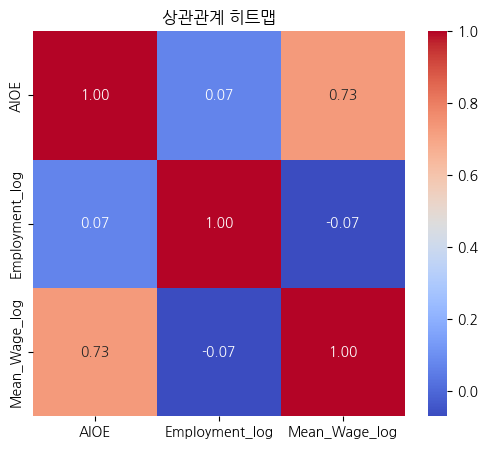

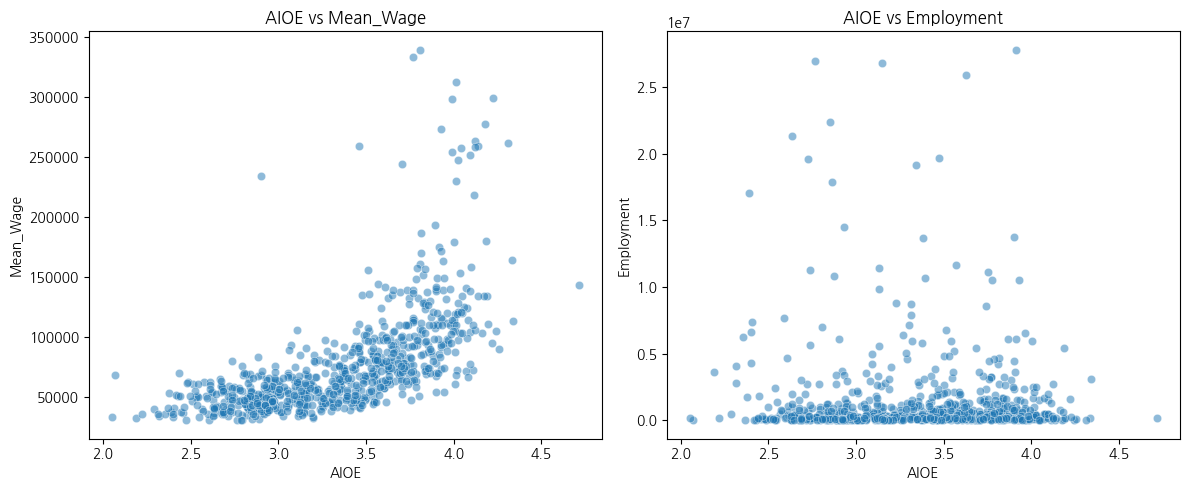

In [14]:
plt.figure(figsize=(6,5))
sns.heatmap(df[['AIOE','Employment_log','Mean_Wage_log']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관관계 히트맵")
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.regplot(x='AIOE', y='Mean_Wage', data=df, scatter_kws={'alpha':0.3})
plt.title("AIOE vs Mean_Wage")

plt.subplot(1,2,2)
sns.regplot(x='AIOE', y='Employment_log', data=df, scatter_kws={'alpha':0.3})
plt.title("AIOE vs Employment (Log Transformed)")

plt.tight_layout()
plt.show()

### 💡 Top/Bottom 직업 분석 인사이트

위 결과를 바탕으로 발견한 패턴:

**📈 상위 20개 직업 (High AIOE) 특징:**

**1. 직업군 분포:**
- **교육/학술**: 교육관리자, 대학교수 (물리학, 법학)
- **의료**: 신경과의사, 응급의학의사, 정신과의사, 방사선과의사
- **법률**: 변호사
- **공학**: 광산/지질공학, 원자력공학, 토목공학
- **항공**: 항공교통관제사, 항공기 조종사

**2. 공통점:**
- ✅ **고학력 요구**: 대부분 석사 이상 학위 필요
- ✅ **언어 능력 중심**: 읽기, 쓰기, 말하기가 핵심
- ✅ **인지적 능력**: 분석, 추론, 판단 능력 필요
- ✅ **고임금**: 평균 $100,000 이상 (일부는 $250,000+)
- ✅ **낮은 고용**: 대부분 100만 명 이하

**3. 왜 AI 영향이 큰가?**
- Language Modeling이 강한 언어 이해/생성 능력
- 문서 작성, 법률 분석, 진단 보조 등에 AI 활용 가능
- 하지만 **완전 대체는 어려움** (책임, 윤리, 전문성)

---

**📉 하위 20개 직업 (Low AIOE) 특징:**

**1. 직업군 분포:**
- **청소/관리**: 청소부, 관리인, 조경/정원사, 차량 청소
- **음식 서비스**: 식기 세척, 식당 보조
- **제조/생산**: 고기 포장, 농산물 선별, 섬유 프레스
- **건설**: 페인트공, 도배공, 바닥 샌딩
- **서비스**: 탈의실 안내, 모델

**2. 공통점:**
- ✅ **육체 노동**: 신체적 능력이 핵심
- ✅ **낮은 학력 요구**: 고졸 이하
- ✅ **반복적 작업**: 단순하지만 정교한 손동작
- ✅ **저임금**: 평균 $30,000~$40,000
- ✅ **높은 고용**: 수백만 명 종사 (사회적 영향 큼)

**3. 왜 AI 영향이 작은가?**
- 언어 능력보다 **신체적 능력** 필요
- 로봇 기술은 아직 인간 수준 미달
- 불규칙한 환경에서의 작업 (청소, 요리 보조 등)
- Language Modeling과 거의 무관

---

**🎓 논문 결과와 비교**

Felten et al. (2023)의 Top 5:
1. Telemarketers (텔레마케터)
2. English Language Teachers (영어 교사)
3. Foreign Language Teachers (외국어 교사)
4. History Teachers (역사 교사)
5. Law Teachers (법학 교사)

우리 결과와 유사한 패턴:
- ✅ 교육 분야 직업 다수 포함
- ✅ 법률 관련 직업 상위권
- ✅ 언어 능력이 핵심인 직업들

차이점:
- 텔레마케터는 우리 데이터에 없거나 다른 코드
- 의료, 공학 직업이 더 많이 포함됨

---

**💼 정책 시사점**

**1. 고위험군 (High AIOE):**
- 재교육/전환 교육 필요성 낮음 (AI와 협업 가능)
- AI 도구 활용 교육 강화 필요
- 예: 변호사 → AI 법률 검색 도구 활용

**2. 저위험군 (Low AIOE):**
- 단기적으로는 안전
- 장기적으로는 로봇 기술 발전 주시
- 저임금 문제가 더 시급

## 6. 상위/하위 직업 비교
- AIOE 기준 Top 20, Bottom 20 직업을 확인
- 각 직업의 평균 임금과 고용 규모 함께 비교

In [15]:
top20 = df.nlargest(20, 'AIOE')[['soc_code_clean','Title','AIOE','Employment','Mean_Wage']]
bottom20 = df.nsmallest(20, 'AIOE')[['soc_code_clean','Title','AIOE','Employment','Mean_Wage']]

print("📌 [AIOE 상위 20 직업]")
display(top20)

print("📌 [AIOE 하위 20 직업]")
display(bottom20)

📌 [AIOE 상위 20 직업]


,soc_code_clean,Title,AIOE,Employment,Mean_Wage
734,53-2021,Air Traffic Controllers,4.713966,166090.0,143777.454994
19,11-9032,"Education Administrators, Kindergarten through...",4.339211,3123970.0,113552.852108
134,19-2012,Physicists,4.331572,164340.0,164159.228429
313,29-1217,Neurologists,4.308843,51900.0,262104.635838
131,19-1041,Epidemiologists,4.256735,87800.0,90339.608200
106,17-2151,"Mining and Geological Engineers, Including Min...",4.241699,45350.0,105123.159868
310,29-1214,Emergency Medicine Physicians,4.227288,238450.0,299551.788635
299,29-1127,Speech-Language Pathologists,4.221739,1573350.0,94921.269775
147,19-3039,Neuropsychologists; Clinical Neuropsychologists,4.193342,133370.0,111389.335683
107,17-2161,Nuclear Engineers,4.187892,97560.0,134191.624641


📌 [AIOE 하위 20 직업]


,soc_code_clean,Title,AIOE,Employment,Mean_Wage
672,51-6021,"Pressers, Textile, Garment, and Related Materials",2.051552,179330.0,33364.065131
452,41-9012,Models,2.070007,21770.0,68978.925126
400,35-9021,Dishwashers,2.187656,3626790.0,33160.536314
511,45-2041,"Graders and Sorters, Agricultural Products",2.220184,174460.0,35939.987963
641,51-3023,Slaughterers and Meat Packers,2.288390,444550.0,40657.647509
764,53-7061,Cleaners of Vehicles and Equipment,2.314881,2769210.0,36088.381993
399,35-9011,Dining Room and Cafeteria Attendants and Barte...,2.317372,4074990.0,34191.986655
405,37-2012,Maids and Housekeeping Cleaners,2.353364,6258240.0,36292.749863
554,47-3014,"Helpers--Painters, Paperhangers, Plasterers, a...",2.368565,50890.0,41151.098448
541,47-2141,"Painters, Construction and Maintenance",2.377354,1711780.0,53891.605405


In [ ]:
df.to_csv('../datas/processed/job_aioe_for_modeling.csv', encoding='utf-8', index=False)

## 7. 모델링용 데이터 저장

### 💾 왜 별도로 저장하는가?

**01번 노트북 결과:**
- `job_aioe_processed.csv`: 모든 직업 (결측치 포함)
- 약 1,000개 직업

**02번 노트북 결과:**
- `job_aioe_for_modeling.csv`: 완전한 데이터만
- 747개 직업
- 로그 변환 변수 추가 (`Employment_log`, `Mean_Wage_log`)

### 📦 저장되는 데이터

| 컬럼 | 설명 | 용도 |
|------|------|------|
| `soc_code_clean` | 7자리 SOC 코드 | 직업 식별자 |
| `AIOE` | AI 직업 노출도 점수 | 주요 분석 변수 |
| `Title` | 직업 이름 | 결과 해석용 |
| `Description` | 직업 설명 | 상세 정보 |
| `Employment` | 고용 규모 (명) | 원본 값 |
| `Mean_Wage` | 평균 임금 ($) | 원본 값 |
| `Employment_log` | 고용 규모 (로그) | 모델링용 |
| `Mean_Wage_log` | 평균 임금 (로그) | 모델링용 |

### 🎯 다음 단계

이 데이터는 **03번 노트북 (모델링)**에서 사용됩니다:
- 회귀 모델: AIOE로 임금 예측
- 분류 모델: 직업군 분류
- 클러스터링: 유사 직업 그룹화